In [54]:
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [55]:
# Modelo SIR com theta variando
def f(y, t, theta, sigma):

    S, I, R = y
    N = S + I + R 

    dS = -theta  * S * I/N
    dI = theta  * S * I/N - sigma * I
    dR = sigma * I
    return np.array([dS, dI, dR])


In [56]:
# Jacobianas para sensitividades
J = autograd.jacobian(f, argnum=0)
grad_theta = autograd.jacobian(f, argnum=2)
grad_sigma  = autograd.jacobian(f, argnum=3)

In [57]:
def ODESYS(Y, t, theta, sigma):
    dy_dt = f(Y[:3], t, theta, sigma)

    sensitivities = Y[3:].reshape(3, 2)
    
    grad = J(Y[:3], t, theta, sigma) @ sensitivities + np.stack([
        grad_theta(Y[:3], t, theta, sigma),
        grad_sigma(Y[:3], t, theta, sigma)
    ], axis=1)
    
    return np.concatenate([dy_dt, grad.flatten()])

In [58]:
def Cost(y_obs):
    def cost(Y):
        n = y_obs.shape[0] # Pegar o número de observações, ou seja, as linhas.
        err = np.linalg.norm(y_obs - Y, 2, axis=1)
        return np.mean(err)/n
    return cost


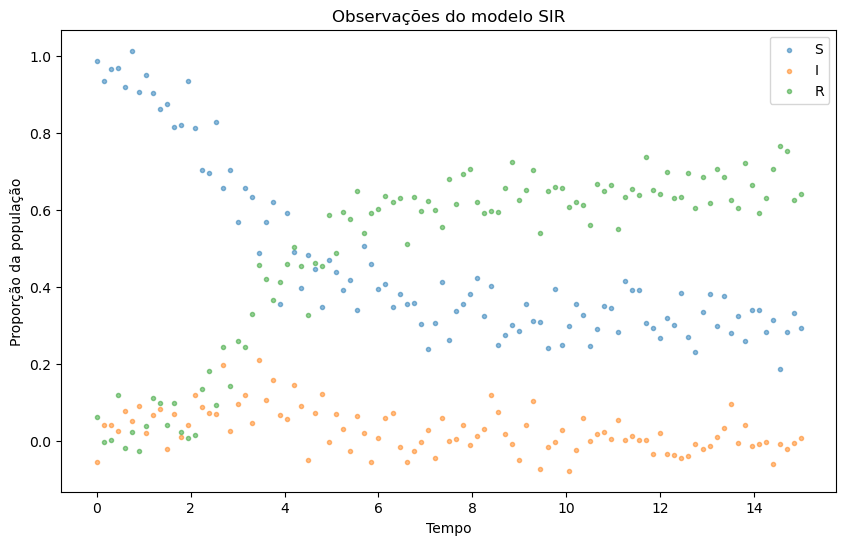

In [59]:
np.random.seed(19920908)
# 3 states + 3×2 sensitivities = 9 total variables
Y0 = np.concatenate([np.array([0.97, 0.01, 0.0]), np.zeros(6)])  

t_span = (0, 15)
t_eval = np.linspace(*t_span, 101)
true_theta, true_sigma = 2.8, 1.7  # True parameter values

sol = solve_ivp(
    lambda t, y: ODESYS(y, t, true_theta, true_sigma),
    t_span, Y0, t_eval=t_eval, method='RK45')

y_obs = sol.y[:3].T + np.random.normal(0, 0.05, size=sol.y[:3].T.shape)

# Plot observações
plt.figure(figsize=(10, 6))
plt.scatter(t_eval, y_obs[:, 0], marker=".", alpha=0.5, label="S")
plt.scatter(t_eval, y_obs[:, 1], marker=".", alpha=0.5, label="I")
plt.scatter(t_eval, y_obs[:, 2], marker=".", alpha=0.5, label="R")
plt.legend()
plt.title("Observações do modelo SIR")
plt.xlabel("Tempo")
plt.ylabel("Proporção da população")
plt.show()

Valores verdadeiros: θ=2.8000, σ=1.7000
Chute inicial:       θ=1.8000, σ=1.0000
Iter 0: theta=2.1297, sigma=1.3334, alpha=500.9459, current_cost=0.0014
Iter 5: theta=2.2767, sigma=1.2914, alpha=37.8170, current_cost=0.0010
Iter 10: theta=2.3173, sigma=1.3859, alpha=35.4394, current_cost=0.0010
Iter 15: theta=2.4078, sigma=1.3899, alpha=36.0992, current_cost=0.0009
Iter 20: theta=2.4360, sigma=1.4651, alpha=34.9599, current_cost=0.0009
Iter 25: theta=2.5081, sigma=1.4653, alpha=36.1413, current_cost=0.0009
Iter 30: theta=2.5278, sigma=1.5256, alpha=34.1094, current_cost=0.0009
Iter 35: theta=2.5824, sigma=1.5272, alpha=35.7452, current_cost=0.0009
Iter 40: theta=2.5995, sigma=1.5722, alpha=36.7726, current_cost=0.0008
Iter 45: theta=2.6417, sigma=1.5732, alpha=34.4649, current_cost=0.0008
Iter 50: theta=2.6510, sigma=1.6111, alpha=35.5576, current_cost=0.0008
Iter 55: theta=2.6868, sigma=1.6056, alpha=33.6181, current_cost=0.0008
Iter 60: theta=2.6915, sigma=1.6375, alpha=32.6110, curre

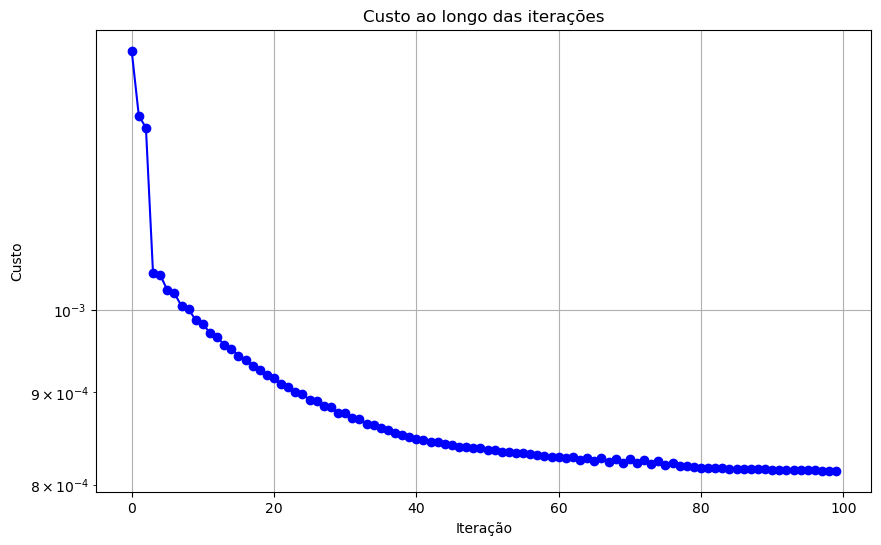

In [ ]:
# %%
# Gradiente descendente com busca linear
theta, sigma = 1.8, 1.0  # Chute inicial (apenas 2 parâmetros)
print(f"Valores verdadeiros: θ={true_theta:.4f}, σ={true_sigma:.4f}")
print(f"Chute inicial:       θ={theta:.4f}, σ={sigma:.4f}")

cost = Cost(y_obs)
grad_c = autograd.grad(cost)

maxiter = 100
prev_cost = 1
tolerance = 1e-6
error_history = []
par_history = []
alpha_history = []

def line_search(theta, sigma, grad, sensitivities, Y, current_cost):
    alpha = 1.0  # Tamanho inicial do passo
    beta = 0.2   # Fator de redução
    c = 1e-4     # Constante para a condição
    new_cost = 2*current_cost

    s = c / np.linalg.norm(grad(Y))**2
    new_sensitivities = sensitivities

    while (new_cost > current_cost) and (s > 1e-10):
        # Reduzir o tamanho do passo
        s *= beta

        # Atualizar os parâmetros com o tamanho do passo atual (apenas 2 parâmetros)
        new_theta = theta - s * (grad(Y) * new_sensitivities[:, :, 0]).sum()
        new_sigma = sigma - s * (grad(Y) * new_sensitivities[:, :, 1]).sum()

        
        # Resolver o sistema com os novos parâmetros
        sol = solve_ivp(
            lambda t, y: ODESYS(y, t, new_theta, new_sigma),
            t_span, Y0, t_eval=t_eval, method='RK45'
        )

        Y_new = sol.y[:3].T
        new_cost = cost(Y_new)
        new_sensitivities = sol.y[3:].T.reshape(-1, 3, 2)  # 3 states × 2 parameters

    # Segunda avaliação para interpolação quadrática
    new_new_theta = new_theta - s * (grad(Y_new) * new_sensitivities[:, :, 0]).sum()
    new_new_sigma = new_sigma - s * (grad(Y_new) * new_sensitivities[:, :, 1]).sum()

    # Resolver o sistema com os novos parâmetros
    sol = solve_ivp(
        lambda t, y: ODESYS(y, t, new_new_theta, new_new_sigma),
        t_span, Y0, t_eval=t_eval, method='RK45')
    
    Y_new_new = sol.y[:3].T
    new_new_cost = cost(Y_new_new)

    # Interpolação quadrática para encontrar o passo ótimo
    div1 = (new_cost - current_cost) / s
    div2 = (new_new_cost - 2*new_cost + current_cost)/(2*s*s)
    alpha = 0.5 * (s - div1/div2)
    
    if alpha < 0:
        print(f"Erro: alpha={alpha:.4f}, s={s:.4f}")
        alpha = s

    return alpha

# Loop principal do gradiente descendente
for i in range(maxiter):
    sol = solve_ivp(
        lambda t, y: ODESYS(y, t, theta, sigma),
        t_span, Y0, t_eval=t_eval, method='RK45')
    Y = sol.y[:3].T

    # Reshape sensitivities para 3 states × 2 parameters
    sensitivities = sol.y[3:].T.reshape(-1, 3, 2)

    current_cost = cost(Y)

    error_history.append(current_cost)
    par_history.append((theta, sigma))
    alpha_history.append(0.0)

    if abs((current_cost - prev_cost)/prev_cost) < tolerance and i > 0:
        print(f"Convergiu na iteração {i}")
        break

    prev_cost = current_cost

    # Chamando Linear Search
    alpha = line_search(theta, sigma, grad_c, sensitivities, Y, current_cost)

    # Atualizar os parâmetros (apenas 2 parâmetros)
    theta -= alpha * (grad_c(Y) * sensitivities[:, :, 0]).sum()
    sigma -= alpha * (grad_c(Y) * sensitivities[:, :, 1]).sum()

    if i % 5 == 0:
        print(f"Iter {i}: theta={theta:.4f}, sigma={sigma:.4f}, alpha={alpha:.4f}, current_cost={current_cost:.4f}")

In [61]:
error_theta = abs(theta - true_theta) / true_theta * 100
error_sigma = abs(sigma - true_sigma) / true_sigma * 100

print(f"Valores estimados:   θ={theta:.4f}, γ={sigma:.4f}")
print("-" * 80)
print("RESULTADOS FINAIS:")
print(f"Valores verdadeiros: θ={true_theta:.4f}, γ={true_sigma:.4f}")
print(f"Valores estimados:   θ={theta:.4f}, γ={sigma:.4f}")
print(f"Erro θ: {error_theta:.2f}%")
print(f"Erro γ: {error_sigma:.2f}%")
print(f"Custo final: {current_cost:.6f}")
print(f"Iterações: {len(error_history)}")

# %%
print(f"Valores estimados:   θ={theta:.4f}, γ={sigma:.4f}")
print(f"Custo final: {current_cost:.6f}")
print(f"Iterações: {len(error_history)}")

Valores estimados:   θ=2.7935, γ=1.6966
--------------------------------------------------------------------------------
RESULTADOS FINAIS:
Valores verdadeiros: θ=2.8000, γ=1.7000
Valores estimados:   θ=2.7935, γ=1.6966
Erro θ: 0.23%
Erro γ: 0.20%
Custo final: 0.000815
Iterações: 100
Valores estimados:   θ=2.7935, γ=1.6966
Custo final: 0.000815
Iterações: 100


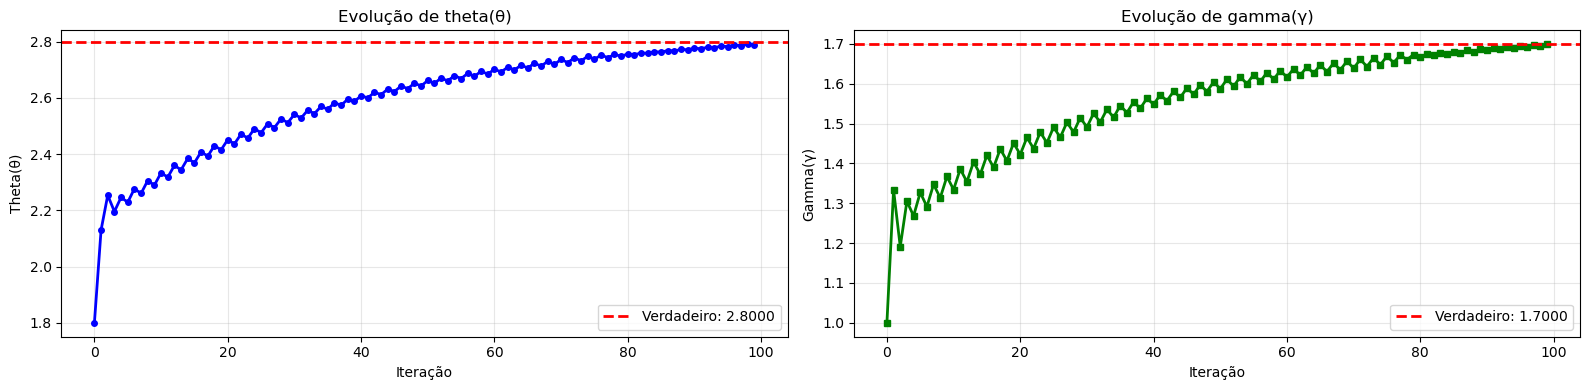

In [62]:
# Plot da evolução dos parâmetros durante a otimização
par_history = np.array(par_history)

plt.figure(figsize=(16, 4))

# Subplot 1: theta
plt.subplot(1, 2, 1)
plt.plot(par_history[:, 0], 'b-', linewidth=2, marker='o', markersize=4)
plt.axhline(y=true_theta, color='r', linestyle='--', linewidth=2, label=f'Verdadeiro: {true_theta:.4f}')
plt.xlabel('Iteração')
plt.ylabel('Theta(θ)')
plt.title('Evolução de theta(θ)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: gamma
plt.subplot(1, 2, 2)
plt.plot(par_history[:, 1], 'g-', linewidth=2, marker='s', markersize=4)
plt.axhline(y=true_sigma, color='r', linestyle='--', linewidth=2, label=f'Verdadeiro: {true_sigma:.4f}')
plt.xlabel('Iteração')
plt.ylabel('Gamma(γ)')
plt.title('Evolução de gamma(γ)')
plt.legend()
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

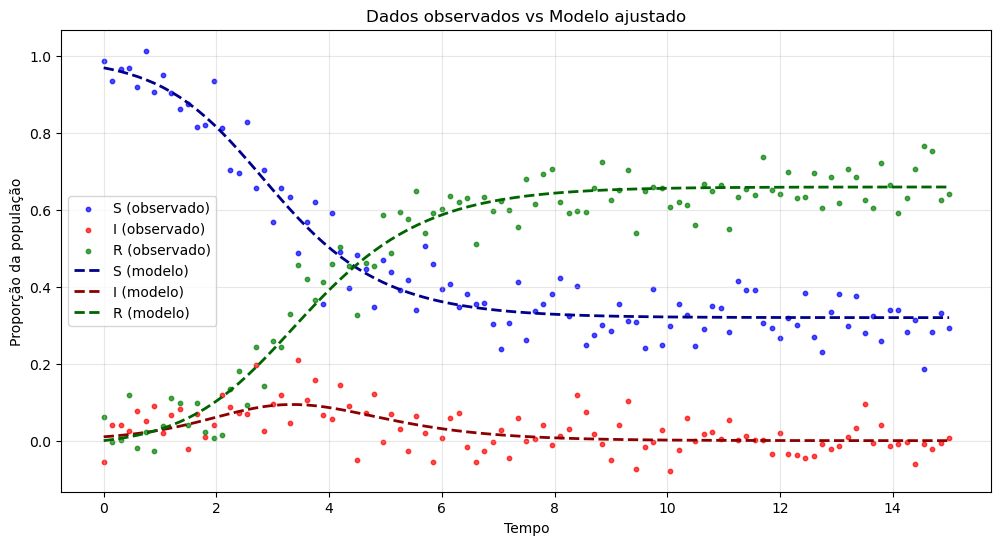

In [63]:
# Plot 1: Observações vs modelo final
sol_final = solve_ivp(
    lambda t, y: ODESYS(y, t, theta, sigma),
    t_span, Y0, t_eval=t_eval, method='RK45'
)
y_final = sol_final.y[:3].T

plt.figure(figsize=(12, 6))

plt.scatter(t_eval, y_obs[:, 0], alpha=0.7, label='S (observado)', color='blue', s=10)
plt.scatter(t_eval, y_obs[:, 1], alpha=0.7, label='I (observado)', color='red', s=10)
plt.scatter(t_eval, y_obs[:, 2], alpha=0.7, label='R (observado)', color='green', s=10)

plt.plot(t_eval, y_final[:, 0], '--', label='S (modelo)', color='darkblue', linewidth=2)
plt.plot(t_eval, y_final[:, 1], '--', label='I (modelo)', color='darkred', linewidth=2)
plt.plot(t_eval, y_final[:, 2], '--', label='R (modelo)', color='darkgreen', linewidth=2)

plt.xlabel('Tempo')
plt.ylabel('Proporção da população')
plt.title('Dados observados vs Modelo ajustado')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()